In [13]:
# --- Cell 1: Import Libraries ---
import pandas as pd
import numpy as np
import os
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [14]:
# --- Cell 2: Advanced Data Loading and Cleaning ---
def clean_text(text):
    """Applies a series of cleaning steps to the text."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_preprocess_data(paths):
    """Loads data from multiple sources with robust, specific labeling."""
    all_data = []
    for path in paths:
        try:
            df_temp = None
            filename = os.path.basename(path)
            if filename in ['SMSSpamCollection', 'Spam_SMS.csv', 'sms.csv']:
                if 'SMSSpamCollection' in filename:
                    df_temp = pd.read_csv(path, sep='\t', header=None, names=["Category", "Message"])
                else:
                    df_temp = pd.read_csv(path, encoding='latin1')
                    df_temp.columns = ["Category", "Message"][:len(df_temp.columns)]
                df_temp['Label'] = df_temp['Category'].map({'ham': 'Legitimate', 'spam': 'Spam'})
                df_temp['Type'] = 'SMS'
            else: # Assumes all other files are emails
                df_temp = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
                if 'body' in df_temp.columns and 'subject' in df_temp.columns:
                     df_temp['Message'] = df_temp['subject'].fillna('') + ' ' + df_temp['body'].fillna('')
                elif 'Message' in df_temp.columns:
                     pass
                else:
                     df_temp['Message'] = df_temp.iloc[:, 1].astype(str)
                if any(k in filename for k in ['CEAS', 'Nazario', 'Nigerian_Fraud']):
                    df_temp['Label'] = 'Phishing'
                elif any(k in filename for k in ['Enron', 'Ling', 'SpamAssasin']):
                    df_temp['Label'] = df_temp['label'].map({0: 'Legitimate', 1: 'Spam'})
                df_temp['Type'] = 'Email'
            if df_temp is not None:
                all_data.append(df_temp[['Message', 'Label', 'Type']])
        except FileNotFoundError:
            print(f"Warning: Skipping file {path}. Not found.")
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")
    if not all_data:
        raise ValueError("No data loaded. Please check file paths and formats.")
    df_full = pd.concat(all_data, ignore_index=True).dropna(subset=["Message", "Label"])
    df_full['CleanMessage'] = df_full['Message'].apply(clean_text)
    return df_full


In [15]:
# --- Cell 3: Feature Engineering ---
def extract_meta_features(df):
    """Creates new features based on the message content."""
    df['message_len'] = df['CleanMessage'].apply(len)
    df['word_count'] = df['CleanMessage'].apply(lambda x: len(x.split()))
    df['percent_caps'] = df['Message'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))
    df['url_count'] = df['Message'].astype(str).str.count(r'http[s]?://|www\.')
    return df

In [16]:

# --- Cell 4: Main Data Preparation ---
paths = [
    "datasets/CEAS_08.csv", "datasets/Enron.csv", "datasets/Ling.csv", "datasets/Nazario.csv", "datasets/Nigerian_Fraud.csv",
    "datasets/sms.csv", "datasets/SMSSpamCollection", "datasets/Spam_SMS.csv", "datasets/SpamAssasin.csv", "datasets/phishing_email.csv"
]
df_full = load_and_preprocess_data(paths)
df_full = extract_meta_features(df_full)
df_sms = df_full[df_full['Type'] == 'SMS'].copy()
df_email = df_full[df_full['Type'] == 'Email'].copy()
sms_class_map = {0: 'Legitimate', 1: 'Spam'}
email_class_map = {0: 'Legitimate', 1: 'Spam', 2: 'Phishing'}
df_sms['LabelNum'] = df_sms['Label'].map({v: k for k, v in sms_class_map.items()})
df_email['LabelNum'] = df_email['Label'].map({v: k for k, v in email_class_map.items()})
df_full['TypeNum'] = df_full['Type'].map({'SMS': 0, 'Email': 1})
df_sms.dropna(subset=['LabelNum', 'CleanMessage'], inplace=True)
df_email.dropna(subset=['LabelNum', 'CleanMessage'], inplace=True)
df_full.dropna(subset=['TypeNum', 'CleanMessage'], inplace=True)
print("Data Loading, Cleaning, and Feature Engineering Complete.")
print(f"Total Samples: {len(df_full)}, SMS Samples: {len(df_sms)}, Email Samples: {len(df_email)}")
print("\nEmail Class Distribution (Original):\n", df_email['Label'].value_counts())
print("\nSMS Class Distribution (Original):\n", df_sms['Label'].value_counts())


Skipping datasets/phishing_email.csv due to error: "['Label'] not in index"
Data Loading, Cleaning, and Feature Engineering Complete.
Total Samples: 99204, SMS Samples: 16718, Email Samples: 82486

Email Class Distribution (Original):
 Label
Phishing      44051
Legitimate    22283
Spam          16152
Name: count, dtype: int64

SMS Class Distribution (Original):
 Label
Legitimate    14477
Spam           2241
Name: count, dtype: int64



Plotting Original Class Distributions...


C:\Users\admin\AppData\Local\Temp\ipykernel_13736\1344445279.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_sms, palette='viridis').set_title('Original SMS Class Distribution')
C:\Users\admin\AppData\Local\Temp\ipykernel_13736\1344445279.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_email, palette='plasma', order=['Legitimate', 'Spam', 'Phishing']).set_title('Original Email Class Distribution')


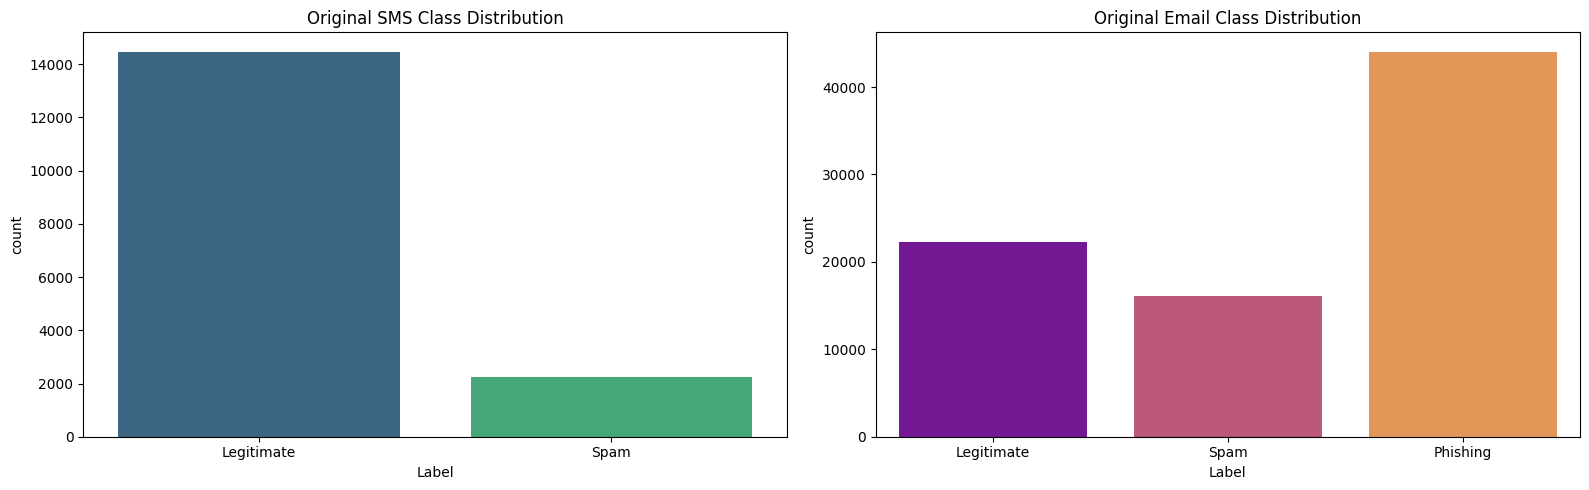

In [17]:
# --- Cell 5: Data Visualization (EDA) ---
print("\nPlotting Original Class Distributions...")
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Label', data=df_sms, palette='viridis').set_title('Original SMS Class Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=df_email, palette='plasma', order=['Legitimate', 'Spam', 'Phishing']).set_title('Original Email Class Distribution')
plt.tight_layout()
plt.show()

In [ ]:
# --- Cell 6: Visualize Class Balance After Applying SMOTE (User Requested Style) ---
def visualize_smote_effect(X_sms_train, y_sms_train, X_email_train, y_email_train, preprocessor):
    """
    Creates a single plot showing the 'after' picture of data balancing
    for both SMS and Email side-by-side.
    """
    print("\nVisualizing Class Balance After Applying SMOTE for Training Data...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    smote = SMOTE(random_state=42)

    # --- SMS Plot ---
    X_sms_train_transformed = preprocessor.fit_transform(X_sms_train)
    _, y_sms_resampled = smote.fit_resample(X_sms_train_transformed, y_sms_train)
    sns.countplot(x=y_sms_resampled, ax=axes[0], palette='viridis')
    axes[0].set_title('SMS Class Distribution After SMOTE')
    axes[0].set_xticklabels(['Legitimate', 'Spam'])
    axes[0].set_xlabel("Class")

    # --- Email Plot ---
    # NOTE: We use fit_transform for the first model (SMS) and transform for the second (Email)
    # This is a simplification for visualization; the actual pipeline handles this correctly.
    X_email_train_transformed = preprocessor.transform(X_email_train)
    _, y_email_resampled = smote.fit_resample(X_email_train_transformed, y_email_train)
    sns.countplot(x=y_email_resampled, ax=axes[1], palette='plasma')
    axes[1].set_title('Email Class Distribution After SMOTE')
    axes[1].set_xticklabels(['Legitimate', 'Spam', 'Phishing'])
    axes[1].set_xlabel("Class")

    plt.tight_layout()
    plt.show()

# --- Cell 7: Build Professional Preprocessing Pipeline ---
numeric_features = ['message_len', 'word_count', 'percent_caps', 'url_count']
text_feature = 'CleanMessage'
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000), text_feature),
        ('scaler', StandardScaler(), numeric_features)
    ],
    remainder='drop')